#  Mammographic Mass Data Set

- ML problem: Classification
- Motivation: ML models can automate the classification of breast masses, for earlier detection and treatment.






### Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


### Data exploration and pre-processing

6 Attributes in total (1 goal field, 1 non-predictive, 4 predictive attributes)



1. BI-RADS assessment: 1 to 5 (ordinal, **non-predictive!**)  

2. Age: patient's age in years (integer)

3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)

4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)

5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)

6. Severity: benign=0 or malignant=1 (binominal, goal field!)

In [3]:
data = pd.read_csv('mammographic_masses.data', na_values='?', header=None, names=['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity']) 
data.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [4]:
## Eliminating "BI-RADS" column

df = data.drop('BI-RADS', axis=1)

In [5]:
## Missing values

df.isnull().sum()

Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

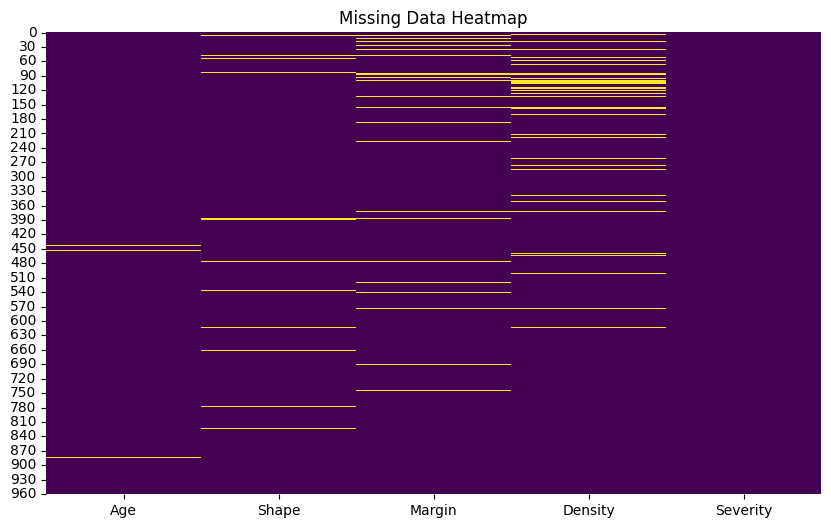

In [6]:
## Heatmap to visualize missing values

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [7]:
## Eliminating missing values

df = df.dropna()
df.describe()

,Age,Shape,Margin,Density,Severity
count,831.000000,831.000000,831.000000,831.000000,831.000000
mean,55.777377,2.783394,2.814681,2.915764,0.484958
std,14.663528,1.242331,1.566771,0.350737,0.500075
min,18.000000,1.000000,1.000000,1.000000,0.000000
25%,46.000000,2.000000,1.000000,3.000000,0.000000
50%,57.000000,3.000000,3.000000,3.000000,0.000000
75%,66.000000,4.000000,4.000000,3.000000,1.000000
max,96.000000,4.000000,5.000000,4.000000,1.000000


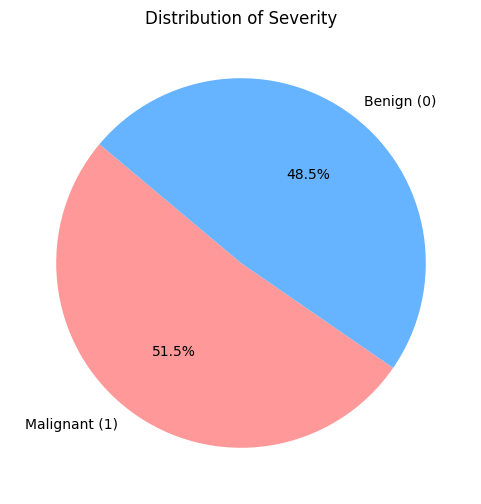

In [8]:
## Severity distribution

plt.figure(figsize=(6,6))
plt.pie(df['Severity'].value_counts(), labels=['Malignant (1)', 'Benign (0)'], autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Distribution of Severity')
plt.show()

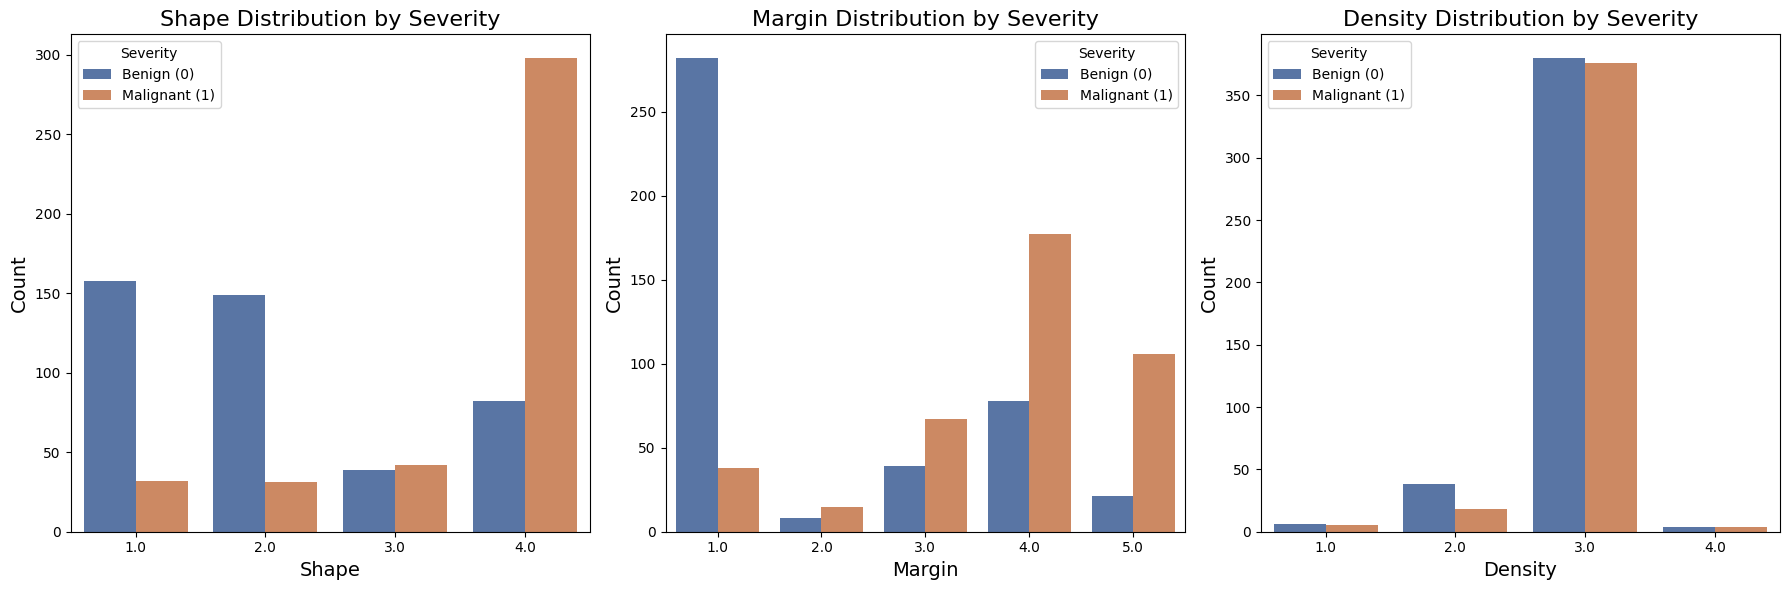

In [9]:
plt.figure(figsize=(18, 6))
for i, col in enumerate(['Shape', 'Margin', 'Density'], 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df, x=col, hue='Severity', palette='deep')
    plt.title(f'{col} Distribution by Severity', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(title='Severity', labels=['Benign (0)', 'Malignant (1)'])

plt.tight_layout()
plt.show()

# margin and shape seem to be strong indicators of severity

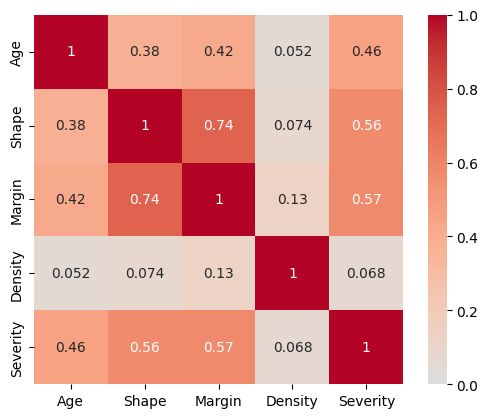

In [11]:
## Correlation matrix

correlation_matrix = df.corr()

axis_corr = sns.heatmap(
correlation_matrix,
vmin=0, vmax=1, center=0,
cmap= 'coolwarm',
annot=True,
square=True
)

plt.show() 

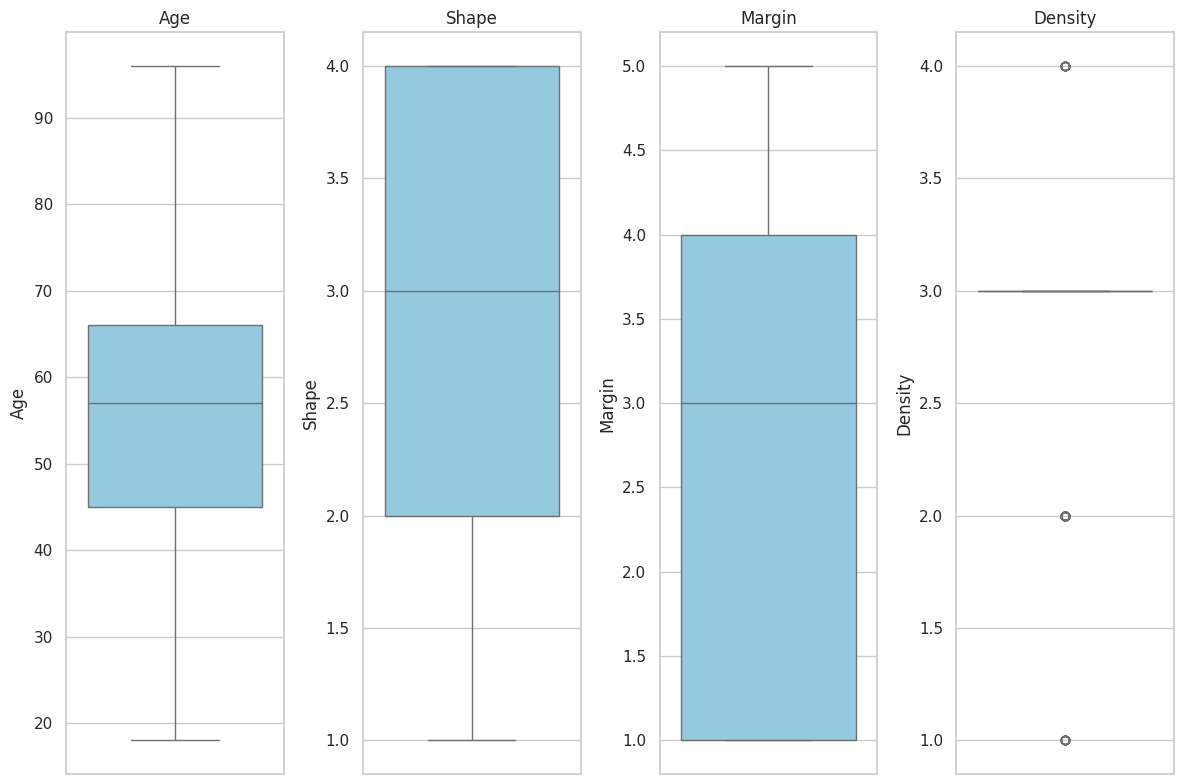

In [12]:
## Outliers

sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
for i, column in enumerate(['Age', 'Shape', 'Margin', 'Density'],1):
    plt.subplot(1, 4, i)  # 2 rows, 3 columns of subplots
    sns.boxplot(y=data[column], color='skyblue')
    plt.title(f'{column}')

plt.tight_layout()
plt.show()